In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Apr 12 02:17:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from sklearn.datasets import fetch_lfw_people, fetch_lfw_pairs
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from torchvision import transforms


Getting the Input and Target values

In [4]:
X = np.load("/content/drive/MyDrive/limitorderbook/input.npy") #train data
y  = np.load("/content/drive/MyDrive/limitorderbook/target.npy")
X_test = np.load("/content/drive/MyDrive/limitorderbook/input_test.npy")
y_test = np.load("/content/drive/MyDrive/limitorderbook/target_test.npy")

Data Exploration:

In [5]:
# Check shape of input
print("All data shape:", X.shape)
print("First row shape:", X[0].shape)
print("First image shape:", X[0][0].shape)

All data shape: (2200, 2, 125, 94, 3)
First row shape: (2, 125, 94, 3)
First image shape: (125, 94, 3)


In [6]:
# Check target data 
print(y)

[1 1 1 ... 0 0 0]


In [7]:
def plot_gallery(X, y, offset = 0, n_row = 10, n_col = 2):
    j = 1
    plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom = 0, left =.01, right =.99, top =.90, hspace =.35)
    for i in range(1,n_row+1):
      plt.subplot(n_row, n_col, j)
      j+=1
      plt.imshow(X[i+offset][0]/255)
      plt.title("matched" if y[i+offset] else "mismatched")

      plt.subplot(n_row, n_col, j)
      j+=1
      plt.imshow(X[i+offset][1]/255)

In this script, since each data point has two images variables ending with 1 and 2 correspond to first image and second image

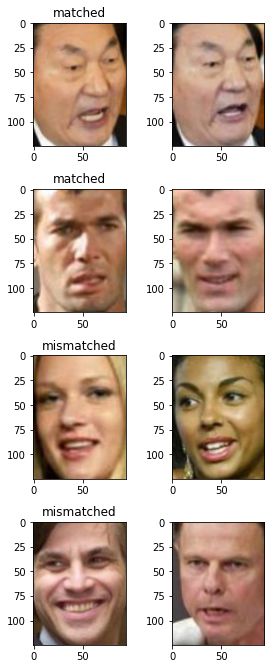

In [8]:
plot_gallery(X,y,1097, 4)

In [9]:
def rescaler(X,size,index):
  X_n = [] 
  for i in range(len(X)):
    img1 = resize(X[i][index]/255,(size,size))
    X_n.append(img1.T)
  X_n = np.array(X_n)
  return X_n

Now that data is properly visualised, rescale data to fit the model input size

In [10]:
X_n1 = rescaler(X,224,0)
X_n2 = rescaler(X,224,1)
X_n1_test = rescaler(X_test,224,0)
X_n2_test = rescaler(X_test,224,1)

In [11]:
means=[0.485, 0.456, 0.406]
stds=[0.229, 0.224, 0.225]

In [12]:
#Normalise
def normalise(X_n):
  for row in range(len(X_n)):
    for image_number in range(2):
      for channel in range(3):
        X_n[row][image_number][channel] = ((X_n[row][image_number][channel]-means[channel])/stds[channel]) 
  return X_n


In [13]:
X_n1 = normalise(X_n1)
X_n2 = normalise(X_n2)
X_n1_test = normalise(X_n1_test)
X_n2_test = normalise(X_n2_test)

In [14]:
# Convert numpy to tensors
X_t1 = torch.from_numpy(X_n1).to(torch.float32)
X_t2 = torch.from_numpy(X_n2).to(torch.float32)
y_t = torch.from_numpy(y).to(torch.float32)

X_t1_test = torch.from_numpy(X_n1_test).to(torch.float32)
X_t2_test = torch.from_numpy(X_n2_test).to(torch.float32)
y_t_test = torch.from_numpy(y_test).to(torch.float32)


In [15]:
# function to normalise the inputs for vgg model
preprocess = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [16]:
train_dataset1 = TensorDataset(X_t1, y_t)
train_dataset2 = TensorDataset(X_t2, y_t)
train_dataloader1 = DataLoader(train_dataset1, batch_size=32,shuffle=False)
train_dataloader2 = DataLoader(train_dataset2, batch_size=32,shuffle=False)

test_dataset1 = TensorDataset(X_t1_test, y_t_test)
test_dataset2 = TensorDataset(X_t2_test, y_t_test)
test_dataloader1 = DataLoader(test_dataset1, batch_size=32,shuffle=False)
test_dataloader2 = DataLoader(test_dataset2, batch_size=32,shuffle=False)

# val_dataloader = DataLoader(val_dataset, batch_size=300)

In [17]:
## Get pretrained VGG
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [18]:
## Show layers
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [19]:
## Remove last layer
model.classifier = nn.Sequential(*list(model.classifier.children())[:-3])


In [20]:
## show layers
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cos = nn.CosineSimilarity()
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Testing without fine-tuning

In [22]:
array = []

## Evaluating on test data
with torch.no_grad():
  i = 0
  for data1,data2 in zip(test_dataloader1,test_dataloader2):
    images1, labels = data1
    images2, labels = data2

    images1 = images1.to(device)
    labels = labels.to(device)

    images2 = images2.to(device)
    
    #forward pass
    output1 = model(images1)
    output2 = model(images2)
    array.append((output1,output2,labels))
    i+=1
    print("Testing.... : ", i)

## Iterating through every set stored in array 
  preds = torch.tensor([])
  labels = torch.tensor([])
  for out1,out2,lab in array:
    pred = cos(out1,out2)
    pred = pred.to('cpu')
    lab = lab.to('cpu')
    preds = torch.cat((preds,pred),0)
    labels = torch.cat((labels,lab),0)

## Converting predictions and true labels into np arrays  
pred_np_raw = preds.numpy()
label_np_raw = labels.numpy()

## obtaining fpr and tpr from the data
fpr_raw,tpr_raw,thresh_raw = roc_curve(label_np_raw,pred_np_raw)
auc_raw = roc_auc_score(label_np_raw,pred_np_raw)

print(f"Untrained AUC : {auc_raw:.2f}")

Testing.... :  1
Testing.... :  2
Testing.... :  3
Testing.... :  4
Testing.... :  5
Testing.... :  6
Testing.... :  7
Testing.... :  8
Testing.... :  9
Testing.... :  10
Testing.... :  11
Testing.... :  12
Testing.... :  13
Testing.... :  14
Testing.... :  15
Testing.... :  16
Testing.... :  17
Testing.... :  18
Testing.... :  19
Testing.... :  20
Testing.... :  21
Testing.... :  22
Testing.... :  23
Testing.... :  24
Testing.... :  25
Testing.... :  26
Testing.... :  27
Testing.... :  28
Testing.... :  29
Testing.... :  30
Testing.... :  31
Testing.... :  32


# Fine-tuning the model

In [23]:
model = model.to(device)
learning_rate = 1e-6
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [24]:
n_total_steps = len(train_dataloader1)
num_epochs = 30
for epoch in range(num_epochs):
  for i,(data1,data2) in enumerate(zip(train_dataloader1,train_dataloader2)):

    images1, labels = data1
    images2, labels = data2

    images1 = images1.to(device)
    labels = labels.to(device)

    images2 = images2.to(device)
    
    #forward pass
    output1 = model(images1)
    output2 = model(images2)

    cos_sim = (cos(output1,output2)+1)/2
    loss = criterion(cos_sim,labels)

    #backwar and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1)%10 ==0:
      print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')

print('Finished Training')


epoch 1/30, step 10/69, loss = 0.0452
epoch 1/30, step 20/69, loss = 0.0409
epoch 1/30, step 30/69, loss = 0.0306
epoch 1/30, step 40/69, loss = 3.3761
epoch 1/30, step 50/69, loss = 2.9014
epoch 1/30, step 60/69, loss = 2.7357
epoch 2/30, step 10/69, loss = 0.0947
epoch 2/30, step 20/69, loss = 0.1146
epoch 2/30, step 30/69, loss = 0.1037
epoch 2/30, step 40/69, loss = 2.1476
epoch 2/30, step 50/69, loss = 1.7408
epoch 2/30, step 60/69, loss = 1.5312
epoch 3/30, step 10/69, loss = 0.2476
epoch 3/30, step 20/69, loss = 0.2865
epoch 3/30, step 30/69, loss = 0.2560
epoch 3/30, step 40/69, loss = 1.3506
epoch 3/30, step 50/69, loss = 1.1168
epoch 3/30, step 60/69, loss = 1.1266
epoch 4/30, step 10/69, loss = 0.3168
epoch 4/30, step 20/69, loss = 0.3698
epoch 4/30, step 30/69, loss = 0.3431
epoch 4/30, step 40/69, loss = 1.0727
epoch 4/30, step 50/69, loss = 0.9146
epoch 4/30, step 60/69, loss = 0.9705
epoch 5/30, step 10/69, loss = 0.3522
epoch 5/30, step 20/69, loss = 0.4111
epoch 5/30, 

In [25]:
data_dir = "/content/drive/MyDrive/limitorderbook/"
torch.save(model.state_dict(), data_dir + 'Vgg_model.pt')

#Testing fine tuned model

In [26]:
array = []

## Evaluating on test data
with torch.no_grad():
  i = 0
  for data1,data2 in zip(test_dataloader1,test_dataloader2):
    images1, labels = data1
    images2, labels = data2

    images1 = images1.to(device)
    labels = labels.to(device)

    images2 = images2.to(device)
    
    #forward pass
    output1 = model(images1)
    output2 = model(images2)
    array.append((output1,output2,labels))
    i+=1
    print("Testing.... : ", i)

## Iterating through every set stored in array 
preds = torch.tensor([])
labels = torch.tensor([])
for out1,out2,lab in array:
  pred = cos(out1,out2)
  pred = pred.to('cpu')
  lab = lab.to('cpu')
  preds = torch.cat((preds,pred),0)
  labels = torch.cat((labels,lab),0)

## Converting predictions and true labels into np arrays  
pred_np_ft = preds.numpy()
label_np_ft = labels.numpy()

## obtaining fpr and tpr from the data
fpr_ft,tpr_ft,thresh_ft = roc_curve(label_np_ft,pred_np_ft)
auc_ft = roc_auc_score(label_np_ft,pred_np_ft)

Testing.... :  1
Testing.... :  2
Testing.... :  3
Testing.... :  4
Testing.... :  5
Testing.... :  6
Testing.... :  7
Testing.... :  8
Testing.... :  9
Testing.... :  10
Testing.... :  11
Testing.... :  12
Testing.... :  13
Testing.... :  14
Testing.... :  15
Testing.... :  16
Testing.... :  17
Testing.... :  18
Testing.... :  19
Testing.... :  20
Testing.... :  21
Testing.... :  22
Testing.... :  23
Testing.... :  24
Testing.... :  25
Testing.... :  26
Testing.... :  27
Testing.... :  28
Testing.... :  29
Testing.... :  30
Testing.... :  31
Testing.... :  32


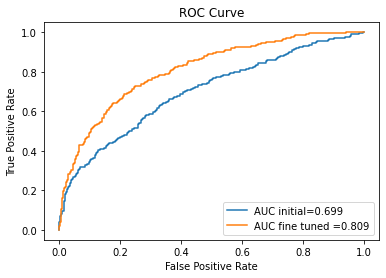

In [29]:
plt.plot(fpr_raw,tpr_raw,label= f"AUC initial={auc_raw:.3f}")
plt.plot(fpr_ft,tpr_ft,label = f"AUC fine tuned ={auc_ft:.3f}")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [28]:
label_np_ft = labels.numpy()

## obtaining fpr and tpr from the data
fpr_ft,tpr_ft,thresh_ft = roc_curve(label_np_ft,pred_np_ft)
auc_ft = roc_auc_score(label_np_ft,pred_np_ft)